<a href="https://colab.research.google.com/github/MOEINSOHA/MOEINSOHA/blob/main/HybridTransformerCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!kaggle datasets download -d johncapocyan/cellnet-beta-version

Dataset URL: https://www.kaggle.com/datasets/johncapocyan/cellnet-beta-version
License(s): MIT
100% 9.67G/9.68G [02:23<00:00, 82.7MB/s]
100% 9.68G/9.68G [02:23<00:00, 72.5MB/s]


In [ ]:
!unzip /content/cellnet-beta-version.zip

In [5]:
import os
import shutil
shutil.rmtree('/content/CellNet')

In [4]:
import shutil
# transfer folders
source_folder = '/content/CellNet/CellNet/Colon_Benign'
destination_folder = '/content/Colon'
shutil.move(source_folder, destination_folder)
print('moved')


moved


In [ ]:
!pip install timm

In [ ]:
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import timm
from tqdm import tqdm

# 1. Device configuration (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2. Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Swin Transformer typically uses 224x224 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Pretrained models expect this normalization
])

# 3. Load dataset
data_path = '/content/Colon'  # Update this path with your dataset path
dataset = ImageFolder(root=data_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# 3.5 Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 4. Load a pre-trained Swin Transformer model (Swin-Tiny, for example)
model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=2).to(device)  # num_classes=2 for benign and adenocarcinoma

# 5. Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# 6. Training loop
def train(model, dataloader, criterion, optimizer, num_epochs=2):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for images, labels in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(dataloader):.4f}")

# 7. Start training
train(model, dataloader, criterion, optimizer, num_epochs=2)




/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

 41%|████      | 128/313 [48:57<1:10:45, 22.95s/it]


KeyboardInterrupt: 

In [ ]:
def evaluate_accuracy(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy on validation set: {accuracy:.2f}%')

# Evaluate the model
evaluate_accuracy(model, val_loader)


Accuracy on validation set: 100.00%


In [ ]:
from sklearn.metrics import precision_score, recall_score

def evaluate_precision_recall(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')

    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')

# Evaluate precision and recall
evaluate_precision_recall(model, val_loader)


Precision: 1.0000
Recall: 1.0000


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

def evaluate_confusion_matrix(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

# Evaluate confusion matrix
evaluate_confusion_matrix(model, val_loader)


Confusion Matrix:
[[1023    0]
 [   0  977]]


Total correct predictions: 32


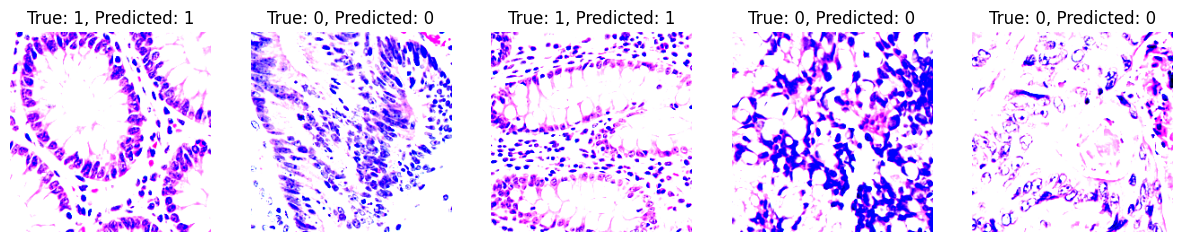

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def evaluate_model_with_images(model, dataloader, num_images=5):
    model.eval()  # Set the model to evaluation mode

    total_correct = 0
    all_images = []
    all_labels = []
    true_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)  # Get the predicted labels
            total_correct += (predicted == labels).sum().item()  # Count correct predictions

            # Collect images and labels
            all_images.extend(images.cpu().numpy())
            all_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())  # Collect true labels

            # Stop if we've collected enough images
            if len(all_images) >= num_images:
                break

    # Calculate the total correct predictions
    print(f"Total correct predictions: {total_correct}")

    # Display images with true and predicted labels
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for ax, img, pred, true in zip(axes, all_images[:num_images], all_labels[:num_images], true_labels[:num_images]):
        ax.imshow(np.transpose(img, (1, 2, 0)))  # Change the color channel order
        ax.set_title(f"True: {true}, Predicted: {pred}")
        ax.axis('off')

    plt.show()

# Example usage:
evaluate_model_with_images(model, val_loader, num_images=5)  # Change num_images to desired number of images


In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 86.1 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 113.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 85.5 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.44.2
    Uninstalling transformers-4.44.2:
      Successfully uninstalled transformers-4.44.2


In [ ]:
import os
import shutil
shutil.rmtree('/content/CellNet')

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from timm import create_model
from PIL import Image
import os

# 1. Dataset definition for MIL (Each image is a "bag", and patches are instances)
class CancerMIL(Dataset):
    def __init__(self, root_dir, transform=None, patch_size=16):
        self.root_dir = root_dir
        self.transform = transform
        self.patch_size = patch_size
        self.image_paths = []
        self.labels = []

        for label, folder in enumerate(['Colon_Benign', 'Colon_Adenocarcinoma']):
            folder_path = os.path.join(root_dir, folder)
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                self.image_paths.append(img_path)
                self.labels.append(label)  # 0 for Colon_Benign, 1 for Colon_Adenocarcinoma

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        # Divide image into patches
        patches = []
        width, height = image.size
        for i in range(0, width, self.patch_size):
            for j in range(0, height, self.patch_size):
                patch = image.crop((i, j, i + self.patch_size, j + self.patch_size))
                if self.transform:
                    patch = self.transform(patch)
                patches.append(patch)

        return torch.stack(patches), label

# 2. Data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjust based on your patch size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 3. Define the dataset and dataloader
# Create the dataset instance first
dataset = CancerMIL(root_dir='/content/Colon', transform=transform)

train_loader = DataLoader(dataset, batch_size=1, shuffle=True)  # Bag-level batch size

# 3.5 Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 4. Define the MIL model using Swin Transformer
class MILModel(nn.Module):
    def __init__(self):
        super(MILModel, self).__init__()
        self.swin = create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=1)  # Use a smaller model
        self.classifier = nn.Linear(1, 1)

    def forward(self, x):
        instance_predictions = []
        # Process patches in smaller batches
        for i in range(0, x.squeeze(0).shape[0], 16):  # Reduced batch to 16 patches at a time
            batch_patches = x.squeeze(0)[i:i + 16]
            instance_pred = self.swin(batch_patches)
            instance_predictions.append(instance_pred)

        instance_predictions = torch.cat(instance_predictions, dim=0)
        bag_prediction = torch.max(instance_predictions)

        return bag_prediction


# 5. Loss function and optimizer
model = MILModel().to('cuda')
criterion = nn.BCEWithLogitsLoss()  # For binary classification
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 6. Training loop for MIL
for epoch in range(3):
    for i, (patches, label) in enumerate(train_loader):
        patches, label = patches.to('cuda'), label.float().to('cuda')

        # Forward pass
        output = model(patches)
        loss = criterion(output, label)

        # Scale loss for gradient accumulation
        loss = loss / accumulation_steps

        # Backward pass
        loss.backward()

        # Update weights every accumulation_steps
        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        print(f'Epoch [{epoch+1}/3], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 15.06 MiB is free. Process 122580 has 14.73 GiB memory in use. Of the allocated memory 13.97 GiB is allocated by PyTorch, and 652.81 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [3]:
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import timm
from tqdm import tqdm

# 1. Device configuration (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2. Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Swin Transformer typically uses 224x224 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Pretrained models expect this normalization
])

# 3. Load dataset
data_path = '/content/Colon'  # Update this path with your dataset path
dataset = ImageFolder(root=data_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# 4. Define a modified model with CNN layers before, Swin Transformer in the middle, and CNN + FC layers after
class CNN_Swin_Transformer_FC(nn.Module):
    def __init__(self, num_classes=2):
        super(CNN_Swin_Transformer_FC, self).__init__()

        # Initial CNN layers
        self.cnn_block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # Start with 3 channels (RGB)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.cnn_block2 = nn.Sequential(
            nn.Conv2d(64, 3, kernel_size=3, padding=1),  # Reduce channels back to 3 for Swin Transformer
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Resize back to 224x224 for Swin Transformer
        self.upsample = nn.Upsample(size=(224, 224), mode='bilinear', align_corners=False)

        # Swin Transformer model (middle part)
        self.swin_transformer = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=0)  # num_classes=0 to get features, not final classification

        # Flattening the feature map for Fully Connected layers
        self.flatten = nn.Flatten()

        # Adjusted FC layers based on feature map size from Swin Transformer
        self.fc_block = nn.Sequential(
            nn.Linear(768 * 7 * 7, 1024),  # Adjust based on feature map size from Swin Transformer
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        # Pass through the initial CNN layers
        x = self.cnn_block1(x)
        x = self.cnn_block2(x)

        # Resize to 224x224 before passing through Swin Transformer
        x = self.upsample(x)

        # Pass through Swin Transformer (features only, no final classification)
        x = self.swin_transformer.forward_features(x)

        print(f"Shape after Swin Transformer: {x.shape}")  # Print the shape after Swin Transformer

        # Reshape to 4D for Fully Connected processing
        x = x.permute(0, 3, 1, 2)  # Rearrange dimensions to (batch_size, channels, height, width)

        # Flatten the output for Fully Connected layers
        x = self.flatten(x)

        # Pass through Fully Connected layers for final classification
        out = self.fc_block(x)

        return out

# 5. Instantiate the model
model = CNN_Swin_Transformer_FC(num_classes=2).to(device)

# 6. Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# 7. Training loop
def train(model, dataloader, criterion, optimizer, num_epochs=2):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for images, labels in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(dataloader):.4f}")

# 8. Start training
train(model, dataloader, criterion, optimizer, num_epochs=2)


  0%|          | 0/313 [00:00<?, ?it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  0%|          | 1/313 [00:01<08:57,  1.72s/it]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  1%|          | 2/313 [00:02<05:53,  1.14s/it]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  1%|          | 3/313 [00:03<04:46,  1.08it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  1%|▏         | 4/313 [00:03<04:21,  1.18it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  2%|▏         | 5/313 [00:04<04:16,  1.20it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  2%|▏         | 6/313 [00:05<04:12,  1.21it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  2%|▏         | 7/313 [00:06<04:09,  1.23it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  3%|▎         | 8/313 [00:06<03:55,  1.30it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  3%|▎         | 9/313 [00:07<03:45,  1.35it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  3%|▎         | 10/313 [00:08<03:39,  1.38it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  4%|▎         | 11/313 [00:08<03:34,  1.41it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  4%|▍         | 12/313 [00:09<03:30,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  4%|▍         | 13/313 [00:10<03:26,  1.46it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  4%|▍         | 14/313 [00:10<03:24,  1.46it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  5%|▍         | 15/313 [00:11<03:22,  1.47it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  5%|▌         | 16/313 [00:12<03:20,  1.48it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  5%|▌         | 17/313 [00:13<03:20,  1.47it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  6%|▌         | 18/313 [00:13<03:19,  1.48it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  6%|▌         | 19/313 [00:14<03:18,  1.48it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  6%|▋         | 20/313 [00:15<03:17,  1.48it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  7%|▋         | 21/313 [00:15<03:16,  1.49it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  7%|▋         | 22/313 [00:16<03:15,  1.49it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  7%|▋         | 23/313 [00:17<03:27,  1.40it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  8%|▊         | 24/313 [00:18<03:36,  1.33it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  8%|▊         | 25/313 [00:18<03:41,  1.30it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  8%|▊         | 26/313 [00:19<03:31,  1.36it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  9%|▊         | 27/313 [00:20<03:26,  1.39it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  9%|▉         | 28/313 [00:20<03:22,  1.41it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  9%|▉         | 29/313 [00:21<03:18,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 10%|▉         | 30/313 [00:22<03:16,  1.44it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 10%|▉         | 31/313 [00:22<03:15,  1.45it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 10%|█         | 32/313 [00:23<03:13,  1.45it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 11%|█         | 33/313 [00:24<03:13,  1.45it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 11%|█         | 34/313 [00:24<03:11,  1.45it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 11%|█         | 35/313 [00:25<03:09,  1.47it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 12%|█▏        | 36/313 [00:26<03:09,  1.46it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 12%|█▏        | 37/313 [00:26<03:07,  1.47it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 12%|█▏        | 38/313 [00:27<03:06,  1.48it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 12%|█▏        | 39/313 [00:28<03:04,  1.48it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 13%|█▎        | 40/313 [00:29<03:06,  1.46it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 13%|█▎        | 41/313 [00:29<03:15,  1.39it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 13%|█▎        | 42/313 [00:30<03:22,  1.34it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 14%|█▎        | 43/313 [00:31<03:22,  1.34it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 14%|█▍        | 44/313 [00:32<03:15,  1.37it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 14%|█▍        | 45/313 [00:32<03:10,  1.41it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 15%|█▍        | 46/313 [00:33<03:06,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 15%|█▌        | 47/313 [00:34<03:04,  1.44it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 15%|█▌        | 48/313 [00:34<03:03,  1.45it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 16%|█▌        | 49/313 [00:35<03:00,  1.46it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 16%|█▌        | 50/313 [00:36<03:01,  1.45it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 16%|█▋        | 51/313 [00:36<03:00,  1.45it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 17%|█▋        | 52/313 [00:37<02:58,  1.46it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 17%|█▋        | 53/313 [00:38<02:57,  1.47it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 17%|█▋        | 54/313 [00:38<02:57,  1.46it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 18%|█▊        | 55/313 [00:39<02:55,  1.47it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 18%|█▊        | 56/313 [00:40<02:55,  1.47it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 18%|█▊        | 57/313 [00:40<02:53,  1.48it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 19%|█▊        | 58/313 [00:41<03:03,  1.39it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 19%|█▉        | 59/313 [00:42<03:10,  1.33it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 19%|█▉        | 60/313 [00:43<03:14,  1.30it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 19%|█▉        | 61/313 [00:44<03:07,  1.34it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 20%|█▉        | 62/313 [00:44<03:01,  1.38it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 20%|██        | 63/313 [00:45<02:58,  1.40it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 20%|██        | 64/313 [00:46<02:54,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 21%|██        | 65/313 [00:46<02:52,  1.44it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 21%|██        | 66/313 [00:47<02:50,  1.44it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 21%|██▏       | 67/313 [00:48<02:50,  1.44it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 22%|██▏       | 68/313 [00:48<02:48,  1.46it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 22%|██▏       | 69/313 [00:49<02:47,  1.45it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 22%|██▏       | 70/313 [00:50<02:46,  1.46it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 23%|██▎       | 71/313 [00:50<02:45,  1.46it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 23%|██▎       | 72/313 [00:51<02:44,  1.46it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 23%|██▎       | 73/313 [00:52<02:44,  1.46it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 24%|██▎       | 74/313 [00:52<02:44,  1.46it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 24%|██▍       | 75/313 [00:53<02:43,  1.46it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 24%|██▍       | 76/313 [00:54<02:52,  1.38it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 25%|██▍       | 77/313 [00:55<02:57,  1.33it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 25%|██▍       | 78/313 [00:56<03:00,  1.30it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 25%|██▌       | 79/313 [00:56<02:53,  1.35it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 26%|██▌       | 80/313 [00:57<02:49,  1.38it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 26%|██▌       | 81/313 [00:58<02:45,  1.40it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 26%|██▌       | 82/313 [00:58<02:42,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 27%|██▋       | 83/313 [00:59<02:41,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 27%|██▋       | 84/313 [01:00<02:39,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 27%|██▋       | 85/313 [01:00<02:38,  1.44it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 27%|██▋       | 86/313 [01:01<02:37,  1.44it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 28%|██▊       | 87/313 [01:02<02:36,  1.45it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 28%|██▊       | 88/313 [01:02<02:35,  1.45it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 28%|██▊       | 89/313 [01:03<02:33,  1.46it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 29%|██▉       | 90/313 [01:04<02:32,  1.46it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 29%|██▉       | 91/313 [01:04<02:31,  1.46it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 29%|██▉       | 92/313 [01:05<02:31,  1.46it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 30%|██▉       | 93/313 [01:06<02:39,  1.38it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 30%|███       | 94/313 [01:07<02:45,  1.32it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 30%|███       | 95/313 [01:08<02:50,  1.28it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 31%|███       | 96/313 [01:08<02:43,  1.33it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 31%|███       | 97/313 [01:09<02:38,  1.36it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 31%|███▏      | 98/313 [01:10<02:34,  1.39it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 32%|███▏      | 99/313 [01:10<02:31,  1.41it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 32%|███▏      | 100/313 [01:11<02:29,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 32%|███▏      | 101/313 [01:12<02:28,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 33%|███▎      | 102/313 [01:12<02:27,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 33%|███▎      | 103/313 [01:13<02:25,  1.45it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 33%|███▎      | 104/313 [01:14<02:23,  1.45it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 34%|███▎      | 105/313 [01:14<02:22,  1.46it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 34%|███▍      | 106/313 [01:15<02:21,  1.46it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 34%|███▍      | 107/313 [01:16<02:20,  1.46it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 35%|███▍      | 108/313 [01:17<02:20,  1.46it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 35%|███▍      | 109/313 [01:17<02:20,  1.45it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 35%|███▌      | 110/313 [01:18<02:20,  1.44it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 35%|███▌      | 111/313 [01:19<02:27,  1.37it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 36%|███▌      | 112/313 [01:20<02:32,  1.32it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 36%|███▌      | 113/313 [01:20<02:30,  1.33it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 36%|███▋      | 114/313 [01:21<02:25,  1.36it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 37%|███▋      | 115/313 [01:22<02:22,  1.39it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 37%|███▋      | 116/313 [01:22<02:20,  1.40it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 37%|███▋      | 117/313 [01:23<02:18,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 38%|███▊      | 118/313 [01:24<02:18,  1.41it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 38%|███▊      | 119/313 [01:25<02:18,  1.40it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 38%|███▊      | 120/313 [01:25<02:16,  1.41it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 39%|███▊      | 121/313 [01:26<02:14,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 39%|███▉      | 122/313 [01:27<02:13,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 39%|███▉      | 123/313 [01:27<02:12,  1.44it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 40%|███▉      | 124/313 [01:28<02:10,  1.44it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 40%|███▉      | 125/313 [01:29<02:10,  1.44it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 40%|████      | 126/313 [01:29<02:09,  1.44it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 41%|████      | 127/313 [01:30<02:09,  1.44it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 41%|████      | 128/313 [01:31<02:15,  1.37it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 41%|████      | 129/313 [01:32<02:20,  1.31it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 42%|████▏     | 130/313 [01:33<02:22,  1.29it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 42%|████▏     | 131/313 [01:33<02:16,  1.34it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 42%|████▏     | 132/313 [01:34<02:12,  1.36it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 42%|████▏     | 133/313 [01:35<02:09,  1.39it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 43%|████▎     | 134/313 [01:35<02:07,  1.41it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 43%|████▎     | 135/313 [01:36<02:05,  1.41it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 43%|████▎     | 136/313 [01:37<02:04,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 44%|████▍     | 137/313 [01:37<02:04,  1.41it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 44%|████▍     | 138/313 [01:38<02:03,  1.41it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 44%|████▍     | 139/313 [01:39<02:02,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 45%|████▍     | 140/313 [01:39<02:00,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 45%|████▌     | 141/313 [01:40<01:59,  1.44it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 45%|████▌     | 142/313 [01:41<01:58,  1.44it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 46%|████▌     | 143/313 [01:42<01:58,  1.44it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 46%|████▌     | 144/313 [01:42<01:57,  1.44it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 46%|████▋     | 145/313 [01:43<02:04,  1.35it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 47%|████▋     | 146/313 [01:44<02:08,  1.29it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 47%|████▋     | 147/313 [01:45<02:10,  1.27it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 47%|████▋     | 148/313 [01:45<02:05,  1.32it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 48%|████▊     | 149/313 [01:46<02:01,  1.35it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 48%|████▊     | 150/313 [01:47<01:58,  1.37it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 48%|████▊     | 151/313 [01:48<01:56,  1.39it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 49%|████▊     | 152/313 [01:48<01:55,  1.40it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 49%|████▉     | 153/313 [01:49<01:53,  1.41it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 49%|████▉     | 154/313 [01:50<01:52,  1.41it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 50%|████▉     | 155/313 [01:50<01:51,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 50%|████▉     | 156/313 [01:51<01:51,  1.41it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 50%|█████     | 157/313 [01:52<01:49,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 50%|█████     | 158/313 [01:52<01:49,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 51%|█████     | 159/313 [01:53<01:48,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 51%|█████     | 160/313 [01:54<01:48,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 51%|█████▏    | 161/313 [01:55<01:46,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 52%|█████▏    | 162/313 [01:55<01:51,  1.35it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 52%|█████▏    | 163/313 [01:56<01:55,  1.30it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 52%|█████▏    | 164/313 [01:57<01:57,  1.26it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 53%|█████▎    | 165/313 [01:58<01:52,  1.31it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 53%|█████▎    | 166/313 [01:59<01:49,  1.34it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 53%|█████▎    | 167/313 [01:59<01:55,  1.27it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 54%|█████▎    | 168/313 [02:00<01:57,  1.23it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 54%|█████▍    | 169/313 [02:01<01:59,  1.20it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 54%|█████▍    | 170/313 [02:02<01:59,  1.20it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 55%|█████▍    | 171/313 [02:03<01:52,  1.26it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 55%|█████▍    | 172/313 [02:03<01:48,  1.31it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 55%|█████▌    | 173/313 [02:04<01:44,  1.34it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 56%|█████▌    | 174/313 [02:05<01:41,  1.37it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 56%|█████▌    | 175/313 [02:05<01:39,  1.39it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 56%|█████▌    | 176/313 [02:06<01:37,  1.40it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 57%|█████▋    | 177/313 [02:07<01:36,  1.41it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 57%|█████▋    | 178/313 [02:08<01:41,  1.33it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 57%|█████▋    | 179/313 [02:09<01:44,  1.28it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 58%|█████▊    | 180/313 [02:09<01:48,  1.23it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 58%|█████▊    | 181/313 [02:10<01:49,  1.20it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 58%|█████▊    | 182/313 [02:11<01:49,  1.20it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 58%|█████▊    | 183/313 [02:12<01:44,  1.25it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 59%|█████▉    | 184/313 [02:13<01:39,  1.30it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 59%|█████▉    | 185/313 [02:13<01:35,  1.34it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 59%|█████▉    | 186/313 [02:14<01:32,  1.37it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 60%|█████▉    | 187/313 [02:15<01:30,  1.39it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 60%|██████    | 188/313 [02:15<01:29,  1.40it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 60%|██████    | 189/313 [02:16<01:28,  1.40it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 61%|██████    | 190/313 [02:17<01:26,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 61%|██████    | 191/313 [02:17<01:25,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 61%|██████▏   | 192/313 [02:18<01:25,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 62%|██████▏   | 193/313 [02:19<01:23,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 62%|██████▏   | 194/313 [02:20<01:27,  1.36it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 62%|██████▏   | 195/313 [02:21<01:39,  1.19it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 63%|██████▎   | 196/313 [02:23<02:16,  1.17s/it]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 63%|██████▎   | 197/313 [02:24<02:07,  1.10s/it]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 63%|██████▎   | 198/313 [02:24<01:53,  1.02it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 64%|██████▎   | 199/313 [02:25<01:42,  1.11it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 64%|██████▍   | 200/313 [02:26<01:34,  1.20it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 64%|██████▍   | 201/313 [02:26<01:29,  1.26it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 65%|██████▍   | 202/313 [02:27<01:24,  1.31it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 65%|██████▍   | 203/313 [02:28<01:21,  1.35it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 65%|██████▌   | 204/313 [02:29<01:19,  1.37it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 65%|██████▌   | 205/313 [02:29<01:17,  1.39it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 66%|██████▌   | 206/313 [02:30<01:16,  1.40it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 66%|██████▌   | 207/313 [02:31<01:15,  1.41it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 66%|██████▋   | 208/313 [02:31<01:13,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 67%|██████▋   | 209/313 [02:32<01:12,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 67%|██████▋   | 210/313 [02:33<01:11,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 67%|██████▋   | 211/313 [02:33<01:11,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 68%|██████▊   | 212/313 [02:34<01:14,  1.35it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 68%|██████▊   | 213/313 [02:35<01:16,  1.30it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 68%|██████▊   | 214/313 [02:36<01:15,  1.30it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 69%|██████▊   | 215/313 [02:37<01:12,  1.34it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 69%|██████▉   | 216/313 [02:37<01:10,  1.37it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 69%|██████▉   | 217/313 [02:38<01:09,  1.39it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 70%|██████▉   | 218/313 [02:39<01:07,  1.41it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 70%|██████▉   | 219/313 [02:39<01:06,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 70%|███████   | 220/313 [02:40<01:05,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 71%|███████   | 221/313 [02:41<01:04,  1.44it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 71%|███████   | 222/313 [02:41<01:03,  1.44it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 71%|███████   | 223/313 [02:42<01:02,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 72%|███████▏  | 224/313 [02:43<01:01,  1.44it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 72%|███████▏  | 225/313 [02:43<01:00,  1.44it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 72%|███████▏  | 226/313 [02:44<01:00,  1.44it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 73%|███████▎  | 227/313 [02:45<00:59,  1.44it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 73%|███████▎  | 228/313 [02:46<00:59,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 73%|███████▎  | 229/313 [02:46<01:02,  1.35it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 73%|███████▎  | 230/313 [02:47<01:03,  1.30it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 74%|███████▍  | 231/313 [02:48<01:04,  1.28it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 74%|███████▍  | 232/313 [02:49<01:01,  1.33it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 74%|███████▍  | 233/313 [02:49<00:58,  1.36it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 75%|███████▍  | 234/313 [02:50<00:57,  1.38it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 75%|███████▌  | 235/313 [02:51<00:55,  1.39it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 75%|███████▌  | 236/313 [02:52<00:54,  1.40it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 76%|███████▌  | 237/313 [02:52<00:54,  1.40it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 76%|███████▌  | 238/313 [02:53<00:53,  1.41it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 76%|███████▋  | 239/313 [02:54<00:51,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 77%|███████▋  | 240/313 [02:54<00:51,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 77%|███████▋  | 241/313 [02:55<00:50,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 77%|███████▋  | 242/313 [02:56<00:49,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 78%|███████▊  | 243/313 [02:56<00:49,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 78%|███████▊  | 244/313 [02:57<00:48,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 78%|███████▊  | 245/313 [02:58<00:47,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 79%|███████▊  | 246/313 [02:59<00:49,  1.35it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 79%|███████▉  | 247/313 [02:59<00:50,  1.30it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 79%|███████▉  | 248/313 [03:00<00:50,  1.28it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 80%|███████▉  | 249/313 [03:01<00:48,  1.32it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 80%|███████▉  | 250/313 [03:02<00:46,  1.35it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 80%|████████  | 251/313 [03:02<00:44,  1.38it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 81%|████████  | 252/313 [03:03<00:43,  1.40it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 81%|████████  | 253/313 [03:04<00:42,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 81%|████████  | 254/313 [03:04<00:41,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 81%|████████▏ | 255/313 [03:05<00:40,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 82%|████████▏ | 256/313 [03:06<00:39,  1.44it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 82%|████████▏ | 257/313 [03:07<00:38,  1.44it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 82%|████████▏ | 258/313 [03:07<00:38,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 83%|████████▎ | 259/313 [03:08<00:37,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 83%|████████▎ | 260/313 [03:09<00:37,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 83%|████████▎ | 261/313 [03:09<00:36,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 84%|████████▎ | 262/313 [03:10<00:35,  1.44it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 84%|████████▍ | 263/313 [03:11<00:36,  1.36it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 84%|████████▍ | 264/313 [03:12<00:37,  1.31it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 85%|████████▍ | 265/313 [03:13<00:37,  1.28it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 85%|████████▍ | 266/313 [03:13<00:35,  1.32it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 85%|████████▌ | 267/313 [03:14<00:34,  1.35it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 86%|████████▌ | 268/313 [03:15<00:32,  1.38it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 86%|████████▌ | 269/313 [03:15<00:31,  1.39it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 86%|████████▋ | 270/313 [03:16<00:30,  1.40it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 87%|████████▋ | 271/313 [03:17<00:29,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 87%|████████▋ | 272/313 [03:17<00:28,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 87%|████████▋ | 273/313 [03:18<00:28,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 88%|████████▊ | 274/313 [03:19<00:27,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 88%|████████▊ | 275/313 [03:19<00:26,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 88%|████████▊ | 276/313 [03:20<00:25,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 88%|████████▊ | 277/313 [03:21<00:25,  1.44it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 89%|████████▉ | 278/313 [03:22<00:24,  1.44it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 89%|████████▉ | 279/313 [03:22<00:23,  1.44it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 89%|████████▉ | 280/313 [03:23<00:24,  1.36it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 90%|████████▉ | 281/313 [03:24<00:24,  1.31it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 90%|█████████ | 282/313 [03:25<00:24,  1.28it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 90%|█████████ | 283/313 [03:25<00:22,  1.32it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 91%|█████████ | 284/313 [03:26<00:21,  1.35it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 91%|█████████ | 285/313 [03:27<00:20,  1.38it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 91%|█████████▏| 286/313 [03:28<00:19,  1.39it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 92%|█████████▏| 287/313 [03:28<00:18,  1.40it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 92%|█████████▏| 288/313 [03:29<00:17,  1.41it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 92%|█████████▏| 289/313 [03:30<00:16,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 93%|█████████▎| 290/313 [03:30<00:16,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 93%|█████████▎| 291/313 [03:31<00:15,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 93%|█████████▎| 292/313 [03:32<00:14,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 94%|█████████▎| 293/313 [03:32<00:14,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 94%|█████████▍| 294/313 [03:33<00:13,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 94%|█████████▍| 295/313 [03:34<00:12,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 95%|█████████▍| 296/313 [03:35<00:11,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 95%|█████████▍| 297/313 [03:35<00:11,  1.37it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 95%|█████████▌| 298/313 [03:36<00:11,  1.31it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 96%|█████████▌| 299/313 [03:37<00:10,  1.28it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 96%|█████████▌| 300/313 [03:38<00:09,  1.32it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 96%|█████████▌| 301/313 [03:38<00:08,  1.35it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 96%|█████████▋| 302/313 [03:39<00:07,  1.38it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 97%|█████████▋| 303/313 [03:40<00:07,  1.40it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 97%|█████████▋| 304/313 [03:40<00:06,  1.41it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 97%|█████████▋| 305/313 [03:41<00:05,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 98%|█████████▊| 306/313 [03:42<00:04,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 98%|█████████▊| 307/313 [03:43<00:04,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 98%|█████████▊| 308/313 [03:43<00:03,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 99%|█████████▊| 309/313 [03:44<00:02,  1.44it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 99%|█████████▉| 310/313 [03:45<00:02,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 99%|█████████▉| 311/313 [03:45<00:01,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


100%|█████████▉| 312/313 [03:46<00:00,  1.43it/s]

Shape after Swin Transformer: torch.Size([16, 7, 7, 768])


100%|██████████| 313/313 [03:46<00:00,  1.38it/s]


Epoch [1/2], Loss: 0.0894


  0%|          | 0/313 [00:00<?, ?it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  0%|          | 1/313 [00:00<03:40,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  1%|          | 2/313 [00:01<04:07,  1.26it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  1%|          | 3/313 [00:02<04:13,  1.23it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  1%|▏         | 4/313 [00:03<04:11,  1.23it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  2%|▏         | 5/313 [00:03<03:58,  1.29it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  2%|▏         | 6/313 [00:04<03:50,  1.33it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  2%|▏         | 7/313 [00:05<03:43,  1.37it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  3%|▎         | 8/313 [00:06<03:39,  1.39it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  3%|▎         | 9/313 [00:06<03:35,  1.41it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  3%|▎         | 10/313 [00:07<03:33,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  4%|▎         | 11/313 [00:08<03:31,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  4%|▍         | 12/313 [00:08<03:30,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  4%|▍         | 13/313 [00:09<03:29,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  4%|▍         | 14/313 [00:10<03:28,  1.44it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  5%|▍         | 15/313 [00:10<03:27,  1.44it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  5%|▌         | 16/313 [00:11<03:27,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  5%|▌         | 17/313 [00:12<03:26,  1.44it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  6%|▌         | 18/313 [00:12<03:25,  1.44it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  6%|▌         | 19/313 [00:13<03:36,  1.36it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  6%|▋         | 20/313 [00:14<03:44,  1.30it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  7%|▋         | 21/313 [00:15<03:50,  1.27it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  7%|▋         | 22/313 [00:16<03:40,  1.32it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  7%|▋         | 23/313 [00:16<03:35,  1.35it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  8%|▊         | 24/313 [00:17<03:30,  1.37it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  8%|▊         | 25/313 [00:18<03:25,  1.40it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  8%|▊         | 26/313 [00:18<03:24,  1.40it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  9%|▊         | 27/313 [00:19<03:22,  1.41it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  9%|▉         | 28/313 [00:20<03:20,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


  9%|▉         | 29/313 [00:21<03:20,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 10%|▉         | 30/313 [00:21<03:18,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 10%|▉         | 31/313 [00:22<03:17,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 10%|█         | 32/313 [00:23<03:59,  1.17it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 11%|█         | 33/313 [00:24<03:46,  1.24it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 11%|█         | 34/313 [00:25<03:37,  1.28it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 11%|█         | 35/313 [00:25<03:33,  1.30it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 12%|█▏        | 36/313 [00:26<03:39,  1.26it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 12%|█▏        | 37/313 [00:27<03:41,  1.25it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 12%|█▏        | 38/313 [00:28<03:33,  1.29it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 12%|█▏        | 39/313 [00:28<03:25,  1.33it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 13%|█▎        | 40/313 [00:29<03:19,  1.37it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 13%|█▎        | 41/313 [00:30<03:16,  1.38it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 13%|█▎        | 42/313 [00:30<03:13,  1.40it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 14%|█▎        | 43/313 [00:31<03:11,  1.41it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 14%|█▍        | 44/313 [00:32<03:09,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 14%|█▍        | 45/313 [00:33<03:08,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 15%|█▍        | 46/313 [00:33<03:06,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 15%|█▌        | 47/313 [00:34<03:05,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 15%|█▌        | 48/313 [00:35<03:04,  1.44it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 16%|█▌        | 49/313 [00:35<03:03,  1.44it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 16%|█▌        | 50/313 [00:36<03:03,  1.44it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 16%|█▋        | 51/313 [00:37<03:02,  1.44it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 17%|█▋        | 52/313 [00:37<03:02,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 17%|█▋        | 53/313 [00:38<03:13,  1.35it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 17%|█▋        | 54/313 [00:39<03:18,  1.31it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 18%|█▊        | 55/313 [00:40<03:19,  1.29it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 18%|█▊        | 56/313 [00:41<03:12,  1.33it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 18%|█▊        | 57/313 [00:41<03:07,  1.37it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 19%|█▊        | 58/313 [00:42<03:03,  1.39it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 19%|█▉        | 59/313 [00:43<03:00,  1.41it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 19%|█▉        | 60/313 [00:43<02:58,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 19%|█▉        | 61/313 [00:44<02:58,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 20%|█▉        | 62/313 [00:45<02:56,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 20%|██        | 63/313 [00:45<02:54,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 20%|██        | 64/313 [00:46<02:53,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 21%|██        | 65/313 [00:47<02:53,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 21%|██        | 66/313 [00:48<02:52,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 21%|██▏       | 67/313 [00:48<02:51,  1.44it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 22%|██▏       | 68/313 [00:49<02:50,  1.44it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 22%|██▏       | 69/313 [00:50<02:48,  1.44it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 22%|██▏       | 70/313 [00:50<02:58,  1.36it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 23%|██▎       | 71/313 [00:51<03:04,  1.31it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 23%|██▎       | 72/313 [00:52<03:07,  1.29it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 23%|██▎       | 73/313 [00:53<03:00,  1.33it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 24%|██▎       | 74/313 [00:53<02:55,  1.36it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 24%|██▍       | 75/313 [00:54<02:51,  1.39it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 24%|██▍       | 76/313 [00:55<02:48,  1.40it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 25%|██▍       | 77/313 [00:56<02:46,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 25%|██▍       | 78/313 [00:56<02:45,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 25%|██▌       | 79/313 [00:57<02:43,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 26%|██▌       | 80/313 [00:58<02:42,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 26%|██▌       | 81/313 [00:58<02:41,  1.44it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 26%|██▌       | 82/313 [00:59<02:39,  1.45it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 27%|██▋       | 83/313 [01:00<02:39,  1.45it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 27%|██▋       | 84/313 [01:00<02:40,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 27%|██▋       | 85/313 [01:01<02:39,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 27%|██▋       | 86/313 [01:02<02:38,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 28%|██▊       | 87/313 [01:03<02:46,  1.35it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 28%|██▊       | 88/313 [01:03<02:53,  1.30it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 28%|██▊       | 89/313 [01:04<02:56,  1.27it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 29%|██▉       | 90/313 [01:05<02:49,  1.32it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 29%|██▉       | 91/313 [01:06<02:45,  1.34it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 29%|██▉       | 92/313 [01:06<02:41,  1.37it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 30%|██▉       | 93/313 [01:07<02:38,  1.39it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 30%|███       | 94/313 [01:08<02:36,  1.40it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 30%|███       | 95/313 [01:08<02:35,  1.41it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 31%|███       | 96/313 [01:09<02:33,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 31%|███       | 97/313 [01:10<02:33,  1.41it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 31%|███▏      | 98/313 [01:11<02:32,  1.41it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 32%|███▏      | 99/313 [01:11<02:32,  1.40it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 32%|███▏      | 100/313 [01:12<02:30,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 32%|███▏      | 101/313 [01:13<02:32,  1.39it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 33%|███▎      | 102/313 [01:13<02:30,  1.41it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 33%|███▎      | 103/313 [01:14<02:29,  1.41it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 33%|███▎      | 104/313 [01:15<02:36,  1.33it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 34%|███▎      | 105/313 [01:16<02:41,  1.29it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 34%|███▍      | 106/313 [01:17<02:43,  1.26it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 34%|███▍      | 107/313 [01:17<02:37,  1.31it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 35%|███▍      | 108/313 [01:18<02:34,  1.33it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 35%|███▍      | 109/313 [01:19<02:30,  1.35it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 35%|███▌      | 110/313 [01:19<02:27,  1.38it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 35%|███▌      | 111/313 [01:20<02:25,  1.39it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 36%|███▌      | 112/313 [01:21<02:23,  1.40it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 36%|███▌      | 113/313 [01:22<02:21,  1.41it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 36%|███▋      | 114/313 [01:22<02:21,  1.41it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 37%|███▋      | 115/313 [01:23<02:20,  1.41it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 37%|███▋      | 116/313 [01:24<02:18,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 37%|███▋      | 117/313 [01:24<02:17,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 38%|███▊      | 118/313 [01:25<02:16,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 38%|███▊      | 119/313 [01:26<02:15,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 38%|███▊      | 120/313 [01:27<02:22,  1.35it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 39%|███▊      | 121/313 [01:27<02:29,  1.29it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 39%|███▉      | 122/313 [01:28<02:36,  1.22it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 39%|███▉      | 123/313 [01:29<02:39,  1.19it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 40%|███▉      | 124/313 [01:30<02:38,  1.19it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 40%|███▉      | 125/313 [01:31<02:29,  1.26it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 40%|████      | 126/313 [01:32<02:23,  1.30it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 41%|████      | 127/313 [01:32<02:18,  1.34it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 41%|████      | 128/313 [01:33<02:15,  1.37it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 41%|████      | 129/313 [01:34<02:13,  1.38it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 42%|████▏     | 130/313 [01:34<02:10,  1.40it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 42%|████▏     | 131/313 [01:35<02:09,  1.41it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 42%|████▏     | 132/313 [01:36<02:08,  1.41it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 42%|████▏     | 133/313 [01:36<02:07,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 43%|████▎     | 134/313 [01:37<02:06,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 43%|████▎     | 135/313 [01:38<02:05,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 43%|████▎     | 136/313 [01:39<02:04,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 44%|████▍     | 137/313 [01:39<02:03,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 44%|████▍     | 138/313 [01:40<02:02,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 44%|████▍     | 139/313 [01:41<02:04,  1.39it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 45%|████▍     | 140/313 [01:42<02:11,  1.32it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 45%|████▌     | 141/313 [01:42<02:13,  1.28it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 45%|████▌     | 142/313 [01:43<02:12,  1.29it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 46%|████▌     | 143/313 [01:44<02:08,  1.33it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 46%|████▌     | 144/313 [01:45<02:04,  1.35it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 46%|████▋     | 145/313 [01:45<02:01,  1.38it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 47%|████▋     | 146/313 [01:46<02:00,  1.39it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 47%|████▋     | 147/313 [01:47<01:58,  1.40it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 47%|████▋     | 148/313 [01:47<01:57,  1.41it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 48%|████▊     | 149/313 [01:48<01:56,  1.40it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 48%|████▊     | 150/313 [01:49<01:55,  1.41it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 48%|████▊     | 151/313 [01:49<01:54,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 49%|████▊     | 152/313 [01:50<01:53,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 49%|████▉     | 153/313 [01:51<01:52,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 49%|████▉     | 154/313 [01:52<01:51,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 50%|████▉     | 155/313 [01:52<01:51,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 50%|████▉     | 156/313 [01:53<01:50,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 50%|█████     | 157/313 [01:54<01:56,  1.34it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 50%|█████     | 158/313 [01:55<01:58,  1.30it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 51%|█████     | 159/313 [01:55<01:59,  1.28it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 51%|█████     | 160/313 [01:56<01:55,  1.33it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 51%|█████▏    | 161/313 [01:57<01:51,  1.36it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 52%|█████▏    | 162/313 [01:58<01:49,  1.37it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 52%|█████▏    | 163/313 [01:58<01:48,  1.39it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 52%|█████▏    | 164/313 [01:59<01:46,  1.40it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 53%|█████▎    | 165/313 [02:00<01:45,  1.41it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 53%|█████▎    | 166/313 [02:00<01:44,  1.41it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 53%|█████▎    | 167/313 [02:01<01:43,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 54%|█████▎    | 168/313 [02:02<01:42,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 54%|█████▍    | 169/313 [02:02<01:41,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 54%|█████▍    | 170/313 [02:03<01:40,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 55%|█████▍    | 171/313 [02:04<01:39,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 55%|█████▍    | 172/313 [02:05<01:39,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 55%|█████▌    | 173/313 [02:05<01:38,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 56%|█████▌    | 174/313 [02:06<01:42,  1.36it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 56%|█████▌    | 175/313 [02:07<01:45,  1.31it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 56%|█████▌    | 176/313 [02:08<01:47,  1.27it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 57%|█████▋    | 177/313 [02:08<01:43,  1.31it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 57%|█████▋    | 178/313 [02:10<02:02,  1.10it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 57%|█████▋    | 179/313 [02:10<01:53,  1.18it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 58%|█████▊    | 180/313 [02:11<01:46,  1.25it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 58%|█████▊    | 181/313 [02:12<01:42,  1.29it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 58%|█████▊    | 182/313 [02:13<01:38,  1.33it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 58%|█████▊    | 183/313 [02:13<01:35,  1.36it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 59%|█████▉    | 184/313 [02:14<01:33,  1.38it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 59%|█████▉    | 185/313 [02:15<01:31,  1.39it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 59%|█████▉    | 186/313 [02:15<01:30,  1.41it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 60%|█████▉    | 187/313 [02:16<01:28,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 60%|██████    | 188/313 [02:17<01:27,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 60%|██████    | 189/313 [02:17<01:26,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 61%|██████    | 190/313 [02:18<01:30,  1.36it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 61%|██████    | 191/313 [02:19<01:33,  1.30it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 61%|██████▏   | 192/313 [02:20<01:36,  1.26it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 62%|██████▏   | 193/313 [02:21<01:32,  1.30it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 62%|██████▏   | 194/313 [02:21<01:29,  1.33it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 62%|██████▏   | 195/313 [02:22<01:27,  1.35it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 63%|██████▎   | 196/313 [02:23<01:24,  1.38it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 63%|██████▎   | 197/313 [02:23<01:22,  1.40it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 63%|██████▎   | 198/313 [02:24<01:21,  1.40it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 64%|██████▎   | 199/313 [02:25<01:20,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 64%|██████▍   | 200/313 [02:26<01:19,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 64%|██████▍   | 201/313 [02:26<01:18,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 65%|██████▍   | 202/313 [02:27<01:17,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 65%|██████▍   | 203/313 [02:28<01:16,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 65%|██████▌   | 204/313 [02:28<01:16,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 65%|██████▌   | 205/313 [02:29<01:15,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 66%|██████▌   | 206/313 [02:30<01:14,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 66%|██████▌   | 207/313 [02:31<01:18,  1.36it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 66%|██████▋   | 208/313 [02:31<01:21,  1.29it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 67%|██████▋   | 209/313 [02:32<01:22,  1.26it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 67%|██████▋   | 210/313 [02:33<01:18,  1.31it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 67%|██████▋   | 211/313 [02:34<01:15,  1.35it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 68%|██████▊   | 212/313 [02:34<01:13,  1.38it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 68%|██████▊   | 213/313 [02:35<01:11,  1.39it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 68%|██████▊   | 214/313 [02:36<01:10,  1.41it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 69%|██████▊   | 215/313 [02:36<01:09,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 69%|██████▉   | 216/313 [02:37<01:08,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 69%|██████▉   | 217/313 [02:38<01:07,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 70%|██████▉   | 218/313 [02:39<01:07,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 70%|██████▉   | 219/313 [02:39<01:06,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 70%|███████   | 220/313 [02:40<01:05,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 71%|███████   | 221/313 [02:41<01:04,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 71%|███████   | 222/313 [02:41<01:03,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 71%|███████   | 223/313 [02:42<01:02,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 72%|███████▏  | 224/313 [02:43<01:05,  1.36it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 72%|███████▏  | 225/313 [02:44<01:07,  1.30it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 72%|███████▏  | 226/313 [02:44<01:08,  1.27it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 73%|███████▎  | 227/313 [02:45<01:05,  1.32it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 73%|███████▎  | 228/313 [02:46<01:03,  1.35it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 73%|███████▎  | 229/313 [02:47<01:01,  1.38it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 73%|███████▎  | 230/313 [02:47<00:59,  1.40it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 74%|███████▍  | 231/313 [02:48<00:58,  1.40it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 74%|███████▍  | 232/313 [02:49<00:57,  1.40it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 74%|███████▍  | 233/313 [02:49<00:56,  1.41it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 75%|███████▍  | 234/313 [02:50<00:55,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 75%|███████▌  | 235/313 [02:51<00:55,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 75%|███████▌  | 236/313 [02:52<00:54,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 76%|███████▌  | 237/313 [02:52<00:53,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 76%|███████▌  | 238/313 [02:53<00:52,  1.44it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 76%|███████▋  | 239/313 [02:54<00:51,  1.44it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 77%|███████▋  | 240/313 [02:54<00:50,  1.44it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 77%|███████▋  | 241/313 [02:55<00:52,  1.37it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 77%|███████▋  | 242/313 [02:56<00:54,  1.31it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 78%|███████▊  | 243/313 [02:57<00:54,  1.28it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 78%|███████▊  | 244/313 [02:57<00:52,  1.32it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 78%|███████▊  | 245/313 [02:58<00:50,  1.35it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 79%|███████▊  | 246/313 [02:59<00:48,  1.38it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 79%|███████▉  | 247/313 [03:00<00:47,  1.40it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 79%|███████▉  | 248/313 [03:00<00:46,  1.40it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 80%|███████▉  | 249/313 [03:01<00:45,  1.41it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 80%|███████▉  | 250/313 [03:02<00:44,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 80%|████████  | 251/313 [03:02<00:43,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 81%|████████  | 252/313 [03:03<00:42,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 81%|████████  | 253/313 [03:04<00:42,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 81%|████████  | 254/313 [03:04<00:41,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 81%|████████▏ | 255/313 [03:05<00:40,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 82%|████████▏ | 256/313 [03:06<00:39,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 82%|████████▏ | 257/313 [03:07<00:39,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 82%|████████▏ | 258/313 [03:07<00:39,  1.39it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 83%|████████▎ | 259/313 [03:08<00:40,  1.32it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 83%|████████▎ | 260/313 [03:09<00:41,  1.28it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 83%|████████▎ | 261/313 [03:10<00:40,  1.30it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 84%|████████▎ | 262/313 [03:10<00:38,  1.33it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 84%|████████▍ | 263/313 [03:11<00:36,  1.36it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 84%|████████▍ | 264/313 [03:12<00:35,  1.38it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 85%|████████▍ | 265/313 [03:13<00:34,  1.40it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 85%|████████▍ | 266/313 [03:13<00:33,  1.41it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 85%|████████▌ | 267/313 [03:14<00:32,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 86%|████████▌ | 268/313 [03:15<00:31,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 86%|████████▌ | 269/313 [03:15<00:30,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 86%|████████▋ | 270/313 [03:16<00:30,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 87%|████████▋ | 271/313 [03:17<00:29,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 87%|████████▋ | 272/313 [03:17<00:28,  1.44it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 87%|████████▋ | 273/313 [03:18<00:27,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 88%|████████▊ | 274/313 [03:19<00:27,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 88%|████████▊ | 275/313 [03:19<00:26,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 88%|████████▊ | 276/313 [03:20<00:27,  1.35it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 88%|████████▊ | 277/313 [03:21<00:27,  1.30it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 89%|████████▉ | 278/313 [03:22<00:27,  1.27it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 89%|████████▉ | 279/313 [03:23<00:25,  1.31it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 89%|████████▉ | 280/313 [03:23<00:24,  1.35it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 90%|████████▉ | 281/313 [03:24<00:23,  1.37it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 90%|█████████ | 282/313 [03:25<00:22,  1.39it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 90%|█████████ | 283/313 [03:25<00:21,  1.40it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 91%|█████████ | 284/313 [03:26<00:20,  1.41it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 91%|█████████ | 285/313 [03:27<00:19,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 91%|█████████▏| 286/313 [03:28<00:18,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 92%|█████████▏| 287/313 [03:28<00:18,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 92%|█████████▏| 288/313 [03:29<00:17,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 92%|█████████▏| 289/313 [03:30<00:16,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 93%|█████████▎| 290/313 [03:30<00:16,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 93%|█████████▎| 291/313 [03:31<00:15,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 93%|█████████▎| 292/313 [03:32<00:14,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 94%|█████████▎| 293/313 [03:33<00:14,  1.36it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 94%|█████████▍| 294/313 [03:33<00:14,  1.30it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 94%|█████████▍| 295/313 [03:34<00:14,  1.26it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 95%|█████████▍| 296/313 [03:35<00:13,  1.31it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 95%|█████████▍| 297/313 [03:36<00:11,  1.34it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 95%|█████████▌| 298/313 [03:36<00:10,  1.36it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 96%|█████████▌| 299/313 [03:37<00:10,  1.39it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 96%|█████████▌| 300/313 [03:38<00:09,  1.40it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 96%|█████████▌| 301/313 [03:39<00:08,  1.40it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 96%|█████████▋| 302/313 [03:39<00:07,  1.41it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 97%|█████████▋| 303/313 [03:40<00:07,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 97%|█████████▋| 304/313 [03:41<00:06,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 97%|█████████▋| 305/313 [03:41<00:05,  1.42it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 98%|█████████▊| 306/313 [03:42<00:04,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 98%|█████████▊| 307/313 [03:43<00:04,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 98%|█████████▊| 308/313 [03:43<00:03,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 99%|█████████▊| 309/313 [03:44<00:02,  1.43it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 99%|█████████▉| 310/313 [03:45<00:02,  1.36it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


 99%|█████████▉| 311/313 [03:46<00:01,  1.30it/s]

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


100%|█████████▉| 312/313 [03:47<00:00,  1.27it/s]

Shape after Swin Transformer: torch.Size([16, 7, 7, 768])


100%|██████████| 313/313 [03:47<00:00,  1.38it/s]

Epoch [2/2], Loss: 0.0076


In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch

# Define function for model evaluation
def evaluate_model(model, dataloader, criterion):
    model.eval()  # Set model to evaluation mode
    all_labels = []
    all_preds = []
    total_loss = 0

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass through the model
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Get the predicted class (max logit score)
            _, preds = torch.max(outputs, 1)

            # Append to lists
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Calculate the metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    avg_loss = total_loss / len(dataloader)

    print(f'Validation Loss: {avg_loss:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-Score: {f1:.4f}')

    return accuracy, precision, recall, f1

# Example usage on the validation set:
evaluate_model(model, val_loader, criterion)


Shape after Swin Transformer: torch.Size([32, 7, 7, 768])
Shape after Swin Transformer: torch.Size([32, 7, 7, 768])
Shape after Swin Transformer: torch.Size([32, 7, 7, 768])
Shape after Swin Transformer: torch.Size([32, 7, 7, 768])
Shape after Swin Transformer: torch.Size([32, 7, 7, 768])
Shape after Swin Transformer: torch.Size([32, 7, 7, 768])
Shape after Swin Transformer: torch.Size([32, 7, 7, 768])
Shape after Swin Transformer: torch.Size([32, 7, 7, 768])
Shape after Swin Transformer: torch.Size([32, 7, 7, 768])
Shape after Swin Transformer: torch.Size([32, 7, 7, 768])
Shape after Swin Transformer: torch.Size([32, 7, 7, 768])
Shape after Swin Transformer: torch.Size([32, 7, 7, 768])
Shape after Swin Transformer: torch.Size([32, 7, 7, 768])
Shape after Swin Transformer: torch.Size([32, 7, 7, 768])
Shape after Swin Transformer: torch.Size([32, 7, 7, 768])
Shape after Swin Transformer: torch.Size([32, 7, 7, 768])
Shape after Swin Transformer: torch.Size([32, 7, 7, 768])
Shape after Sw

(0.9985, 0.998504491017964, 0.9985, 0.9984999988749997)

Shape after Swin Transformer: torch.Size([32, 7, 7, 768])


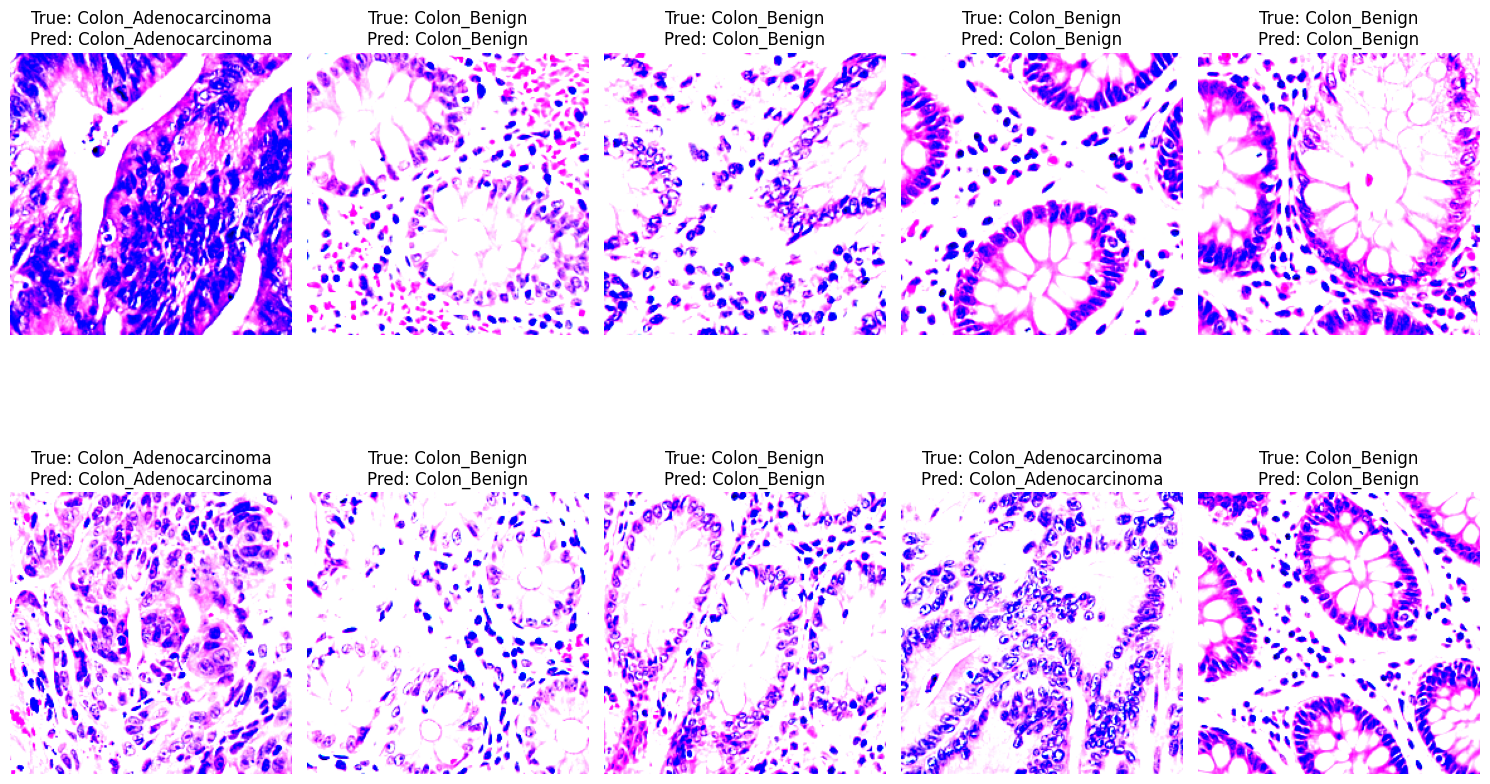

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, dataloader, num_images=10):
    model.eval()  # Set model to evaluation mode
    images, true_labels = next(iter(dataloader))
    images, true_labels = images.to(device), true_labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted_labels = torch.max(outputs, 1)

    # Convert images from tensors to numpy arrays for visualization
    images = images.cpu().numpy()
    images = np.transpose(images, (0, 2, 3, 1))  # Change shape from (N, C, H, W) to (N, H, W, C)

    # Set up the figure
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])
        plt.title(f'True: {dataset.classes[true_labels[i]]}\nPred: {dataset.classes[predicted_labels[i]]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to visualize predictions
visualize_predictions(model, val_loader, num_images=10)
